In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from music21 import *
from fractions import Fraction
seed =0 
torch.manual_seed(seed)

# Import data

In [2]:
class MusicDataset(torch.utils.data.Dataset):

    def __init__(self, right, left, Y, transform = None):
        self.right = right
        self.left = left
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.right[idx], self.left[idx], self.Y[idx]
    

def generate_data_loader(right_data, left_data, labels, batch_size):
    
    X = np.arange(right_data.shape[0])
    y = labels
    X_trainval, X_test, y_trainval, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=23)
    
    # Split train into train-val
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42)

    right_train = right_data[X_train]
    right_val = right_data[X_val]
    right_test = right_data[X_test]
    
    left_train = left_data[X_train]
    left_val = left_data[X_val]
    left_test = left_data[X_test]    
    
    train_data = MusicDataset(torch.from_numpy(right_train).float(), 
                              torch.from_numpy(left_train).float(), 
                             torch.from_numpy(y_train).float())
    val_data = MusicDataset(torch.from_numpy(right_val).float(), 
                            torch.from_numpy(left_val).float(),
                           torch.from_numpy(y_val).float())
    test_data = MusicDataset(torch.from_numpy(right_test).float(),
                             torch.from_numpy(left_test).float(),
                            torch.from_numpy(y_test).float())
        
    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, shuffle=False)
    val_loader = torch.utils.data.DataLoader(
        val_data, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [3]:
right_data = np.load('/Users/fionawu/Documents/2022_Fall/ECE685_Deep_Learning/project/preprocess_data/right_data_small.npy')
left_data = np.load('/Users/fionawu/Documents/2022_Fall/ECE685_Deep_Learning/project/preprocess_data/left_data_small.npy')
labels = np.load('/Users/fionawu/Documents/2022_Fall/ECE685_Deep_Learning/project/preprocess_data/labels_small.npy')
batch_size = 64
train_loader, val_loader, test_loader = generate_data_loader(right_data, left_data, labels, batch_size)

In [4]:
right_data.shape

(2740, 50, 191)

In [5]:
labels = np.expand_dims(labels,axis=1)
labels = np.repeat(labels,50,axis=1)

In [6]:
print(labels.shape)

(2740, 50, 3)


# Model architecture

In [8]:
class CVAE(nn.Module):
    def __init__(self, n_in, n_hid_1,n_hid_2,n_hid_3,n_hid_4, z_dim):  
        super(CVAE, self).__init__()
        
        ##################################### encode layer #####################################
        ### parallel LSTM 
        self.classes = 3 
        self.num_features = 50
        self.fc1r = nn.LSTM(n_in+self.classes,n_hid_1,1,batch_first=True,bidirectional = False) # LSTM for right piano  n_hid_1= 100 
        self.bn1r = nn.BatchNorm1d(self.num_features, affine=False)
        
        self.fc1l = nn.LSTM(n_in+self.classes,n_hid_1,1,batch_first=True,bidirectional = False) # LSTM for right piano  
        self.bn1l = nn.BatchNorm1d(self.num_features, affine=False)
        
        ### dense
        
        self.fc2d1  = nn.Linear(10000,n_hid_2)  # 10000 = 50*200 , n_hid_2= 5000
        #self.bn2d1 = nn.BatchNorm1d(n_hid_2, affine=False)
        self.dropout = nn.Dropout(p=0.5)
        
        self.fc2d2  = nn.Linear(n_hid_2,n_hid_3) # n_hid_3 =2500 
        #self.bn2d2 = nn.BatchNorm1d(n_hid_3, affine=False)
        
        self.fc2d3  = nn.Linear(n_hid_3,n_hid_4) # n_hid_4 =1000
        #self.bn2d3 = nn.BatchNorm1d(n_hid_4, affine=False)
        
        self.fc31 = nn.Linear(n_hid_4,z_dim)  # z_dim= 50
        self.fc32 = nn.Linear(n_hid_4,z_dim)  
        
        ##################################### decode layer #####################################
        ### dense 
        self.fc4d1= nn.Linear(z_dim+self.classes,n_hid_4)
        self.bn4d1 = nn.BatchNorm1d(n_hid_4, affine=False)
        
        self.fc4d2r= nn.Linear(n_hid_4,n_hid_3)
        self.bn4d2r = nn.BatchNorm1d(n_hid_3, affine=False)
        self.fc4d2l= nn.Linear(n_hid_4,n_hid_3)
        self.bn4d2l = nn.BatchNorm1d(n_hid_3, affine=False)
        
        self.fc4d3r= nn.Linear(n_hid_3,n_hid_2)
        self.bn4d3r = nn.BatchNorm1d(n_hid_2, affine=False)
        self.fc4d3l= nn.Linear(n_hid_3,n_hid_2)
        self.bn4d3l = nn.BatchNorm1d(n_hid_2, affine=False)
    
        
        ### parallel LSTM 
        self.fc5r = nn.LSTM(n_hid_1,n_in,1,batch_first=True,bidirectional = False)
        self.bn5r = nn.BatchNorm1d(self.num_features, affine=False)
        self.fc5l = nn.LSTM(n_hid_1,n_in,1,batch_first=True,bidirectional = False)
        self.bn5l = nn.BatchNorm1d(self.num_features, affine=False)
        
    def parallel_lstm(self,x1,x2,label):
        
        ### concat x with label 
        x1_c = torch.cat((x1,label),dim=2)
        x2_c = torch.cat((x2,label),dim=2)
        
        
        output_right,_ = self.fc1r(x1_c)
        output_right = F.relu(self.bn1r(output_right))

        output_left,_ = self.fc1l(x2_c)
        output_left = F.relu(self.bn1l(output_left))
        
        return output_right,output_left  # output_right 
        
    def dense(self,x1,x2,label):
        
        output_right,output_left= self.parallel_lstm(x1,x2,label)
        output = torch.cat((output_right,output_left),dim=-1)  # batch_size*50*200 
        output = output.view(output.size(0),-1)  # convert to batch_size* 10000
        output = self.dropout(output)
        
        dense_1 = self.fc2d1(output)
        dense_1 = F.relu(self.dropout(dense_1))
        
        dense_2 = self.fc2d2(dense_1)
        dense_2 = F.relu(self.dropout(dense_2))
        
        dense_3 = self.fc2d3(dense_2)
        dense_3 = F.relu(dense_3)
       
        return dense_3
    
    def encode(self,x1,x2,label):
        dense=self.dense(x1,x2,label)
        mu = self.fc31(dense)
        logvar = self.fc32(dense) 
        return mu,logvar
    
    def reparameterize(self, mu, logvar):
        
        stdev = torch.exp(0.5*logvar)
        eps = torch.randn_like(stdev)
        z= mu + eps*stdev
        return z 
    
    def decode(self, z, label):
        
        ### concate z with label 
        z= torch.cat((z,label),dim=-1) # z_dim =503
        
        out1 = self.fc4d1(z)
        out1 = F.relu(self.bn4d1(out1))
        
        piano_right = self.fc4d2r(out1)
        piano_right = F.relu(self.bn4d2r(piano_right))
        piano_right = self.fc4d3r(piano_right)
        piano_right = F.relu(self.bn4d3r(piano_right))
        
        
        piano_left = self.fc4d2l(out1)
        piano_left = F.relu(self.bn4d2l(piano_left))
        piano_left = self.fc4d3l(piano_left)
        piano_left = F.relu(self.bn4d3l(piano_left))
        
        piano_right=piano_right.view(piano_right.size(0),50,100)
        piano_left=piano_left.view(piano_left.size(0),50,100)
        
#         out1 = F.relu(self.fc4d1(z))
#         out2 = F.relu(self.fc4d2(out1))
#         out3 = F.relu(self.fc4d3(out2))
        
#         out3=out3.view(out3.size(0),50,200)
      
#         piano_right = F.relu(out3[:,:,0:100])
#         piano_left  = F.relu(out3[:,:,100:200])
    
        
        decode_right,_=self.fc5r(piano_right)
        decode_right = self.bn5r(decode_right)
        decode_left,_=self.fc5l(piano_left)
        decode_left = self.bn5l(decode_left)
        
        right_p = torch.softmax(decode_right[:,:,0:78],dim=2)   # softmax for pitch 
        right_t = torch.softmax(decode_right[:,:,78:115],dim=2) # softmax for pitch duration 
        right_v = torch.softmax(decode_right[:,:,115:191],dim=2) # softmax for velocity 
        output_right = torch.cat((right_p, right_t, right_v), dim=2)
        
        left_p = torch.softmax(decode_left[:,:,0:78],dim=2)
        left_t = torch.softmax(decode_left[:,:,78:115],dim=2)
        left_v = torch.softmax(decode_left[:,:,115:191],dim=2)
        output_left = torch.cat((left_p, left_t, left_v), dim=2)
        return output_right,output_left
    
    def forward(self,x1,x2,label_3d,label):
        mu,logvar = self.encode(x1,x2,label_3d)
        z = self.reparameterize(mu,logvar)
        output_right,output_left = self.decode(z,label)
        
        return output_right,output_left,mu,logvar

In [7]:
def loss_function(recon_right,recon_left, right,left, mu, logvar):
    
    BCE_right = F.cross_entropy(recon_right, right, reduction='mean') # BCE = -Negative Log-likelihood
    BCE_left = F.cross_entropy(recon_left, left, reduction='mean')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL Divergence b/w q_\phi(z|x) || p(z)
    return  BCE_right + BCE_left+ KLD

In [13]:
def train(model,optimizer,train_loader):
    train_loss = 0
    BCE_right_loss = 0 
    BCE_left_loss = 0
    KLD_loss = 0 
    model.train()
    criterion  = nn.MSELoss()
    for idx, (right_data,left_data,label) in enumerate(train_loader):
        ## preprocess label 
        label_3d=torch.unsqueeze(label,1)
        label_3d=label_3d.repeat_interleave(50,dim=1) 
        ### 
        optimizer.zero_grad()
        output_right,output_left,mu,logvar = model(right_data,left_data,label_3d,label)
       
        loss = loss_function(output_right, output_left, right_data, left_data, mu,logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    return  train_loss/len(train_loader)

def val(model,val_loader):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for idx, (right_data,left_data,label) in enumerate(val_loader):
            label_3d=torch.unsqueeze(label,1)
            label_3d=label_3d.repeat_interleave(50,dim=1) 
            
            output_right,output_left,mu,logvar = model(right_data,left_data,label_3d,label)
            
            loss = loss_function(output_right, output_left, right_data, left_data, mu,logvar)
            val_loss += loss.item() # sum up batch loss
   
        return val_loss/len(val_loader)

def plot_loss(train_loss,val_loss):
    
    X=range(1,len(train_loss)+1)
    plt.plot(X,train_loss,"-b",label="Train")
    plt.plot(X,val_loss,"-r",label="Val")
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

In [16]:
model

CVAE(
  (fc1r): LSTM(194, 100, batch_first=True)
  (bn1r): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (fc1l): LSTM(194, 100, batch_first=True)
  (bn1l): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (fc2d1): Linear(in_features=10000, out_features=5000, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2d2): Linear(in_features=5000, out_features=2500, bias=True)
  (fc2d3): Linear(in_features=2500, out_features=1000, bias=True)
  (fc31): Linear(in_features=1000, out_features=50, bias=True)
  (fc32): Linear(in_features=1000, out_features=50, bias=True)
  (fc4d1): Linear(in_features=53, out_features=1000, bias=True)
  (bn4d1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (fc4d2r): Linear(in_features=1000, out_features=2500, bias=True)
  (bn4d2r): BatchNorm1d(2500, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (fc4d2l): Linear(in_features=1000, o

# Model Train

for epoch 1, train loss is 6.39124642099653
for epoch 1, validation loss is 5.275155816759382
for epoch 2, train loss is 4.9217654296330045
for epoch 2, validation loss is 5.047463348933628
for epoch 3, train loss is 4.864215816770281
for epoch 3, validation loss is 4.975548676082066
for epoch 4, train loss is 4.84366158076695
for epoch 4, validation loss is 4.955138955797468
for epoch 5, train loss is 4.83350213936397
for epoch 5, validation loss is 4.947685173579624
for epoch 6, train loss is 4.824980241911752
for epoch 6, validation loss is 4.920448575701032
for epoch 7, train loss is 4.819411652428763
for epoch 7, validation loss is 4.8824672017778665
for epoch 8, train loss is 4.815277968134199
for epoch 8, validation loss is 4.868808610098703
for epoch 9, train loss is 4.811079519135611
for epoch 9, validation loss is 4.828300748552595
for epoch 10, train loss is 4.807067445346287
for epoch 10, validation loss is 4.805055005209787
for epoch 11, train loss is 4.80395109312875
for 

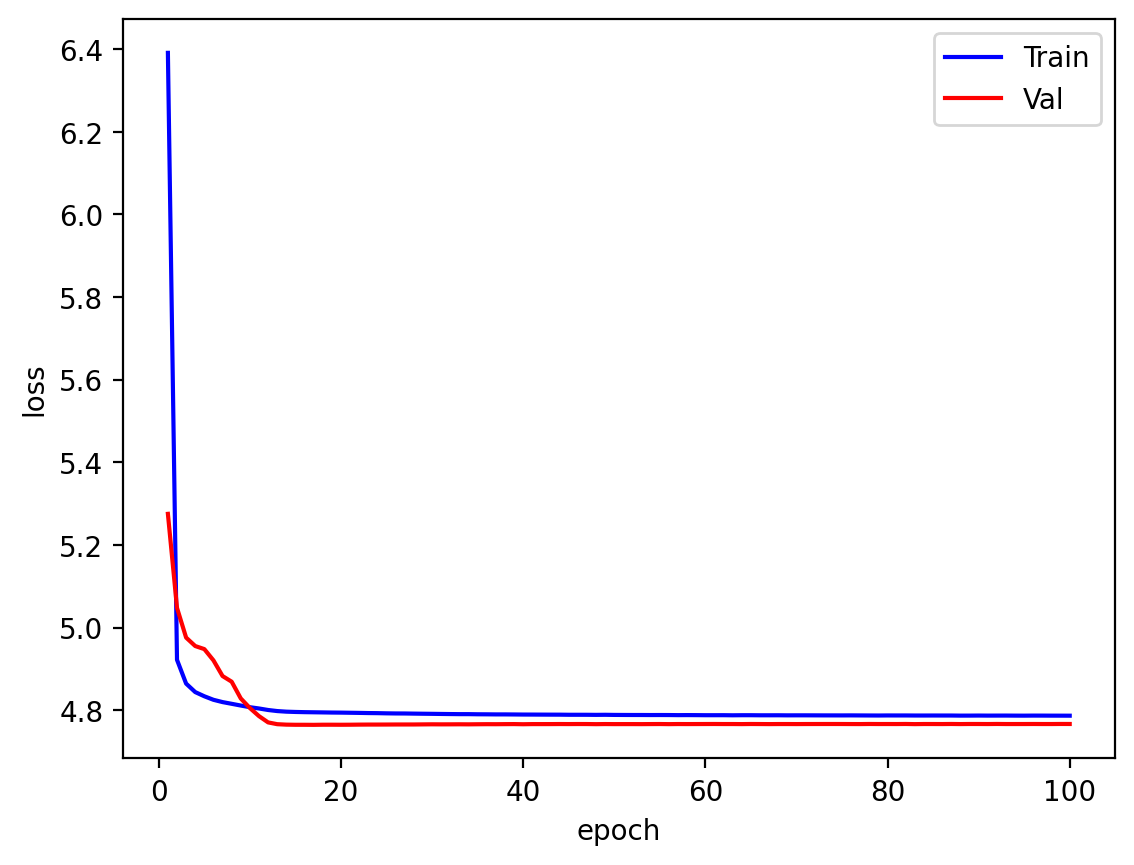

In [14]:
## set general parameters 
n_in=191
n_hid_1=100
n_hid_2=5000
n_hid_3= 2500
n_hid_4 = 1000
z_dim = 50
num_epochs = 100
lr = 0.0001
decay = 0.0001

train_loss_all=[]
val_loss_all = [] 
torch.autograd.set_detect_anomaly(True)

model=CVAE(n_in, n_hid_1,n_hid_2,n_hid_3,n_hid_4,z_dim)
optimizer= optim.Adam(model.parameters(),lr= lr, weight_decay= decay)
for epoch in range(1, num_epochs + 1):
    train_loss = train(model,optimizer,train_loader)
    train_loss_all.append(train_loss)
    print("for epoch {}, train loss is {}".format(epoch,train_loss))
    val_loss = val(model,val_loader)
    val_loss_all.append(val_loss)
    print("for epoch {}, validation loss is {}".format(epoch,val_loss))
plot_loss(train_loss_all,val_loss_all)

# Music Generation

In [18]:
tdict = {0.25: 0,
 0.5: 1,
 0.75: 2,
 1.0: 3,
 1.25: 4,
 1.5: 5,
 1.75: 6,
 2.0: 7,
 2.25: 8,
 2.5: 9,
 2.75: 10,
 3.0: 11,
 3.25: 12,
 4.0: 13,
 5.0: 14,
 6.0: 15,
 3.5: 16,
 3.75: 17,
 4.25: 18,
 4.5: 19,
 4.75: 20,
 5.25: 21,
 5.5: 22,
 7.0: 23,
 Fraction(1, 6): 24,
 Fraction(5, 12): 25,
 Fraction(2, 3): 26,
 Fraction(5, 3): 27,
 Fraction(23, 12): 28,
 Fraction(8, 3): 29,
 Fraction(11, 3): 30,
 Fraction(1, 3): 31,
 Fraction(1, 12): 32,
 Fraction(5, 6): 33,
 Fraction(4, 3): 34,
 Fraction(7, 3): 35,
 Fraction(10, 3): 36}

In [19]:
pdict = {24: 0,
 25: 1,
 26: 2,
 27: 3,
 28: 4,
 29: 5,
 30: 6,
 31: 7,
 32: 8,
 33: 9,
 34: 10,
 35: 11,
 36: 12,
 37: 13,
 38: 14,
 39: 15,
 40: 16,
 41: 17,
 42: 18,
 43: 19,
 44: 20,
 45: 21,
 46: 22,
 47: 23,
 48: 24,
 49: 25,
 50: 26,
 51: 27,
 52: 28,
 53: 29,
 54: 30,
 55: 31,
 56: 32,
 57: 33,
 58: 34,
 59: 35,
 60: 36,
 61: 37,
 62: 38,
 63: 39,
 64: 40,
 65: 41,
 66: 42,
 67: 43,
 68: 44,
 69: 45,
 70: 46,
 71: 47,
 72: 48,
 73: 49,
 74: 50,
 75: 51,
 76: 52,
 77: 53,
 78: 54,
 79: 55,
 80: 56,
 81: 57,
 82: 58,
 83: 59,
 84: 60,
 85: 61,
 86: 62,
 87: 63,
 88: 64,
 89: 65,
 90: 66,
 91: 67,
 92: 68,
 93: 69,
 94: 70,
 95: 71,
 96: 72,
 97: 73,
 98: 74,
 99: 75,
 100: 76,
 101: 77}

In [20]:
vdict = {20: 0,
 21: 1,
 22: 2,
 23: 3,
 24: 4,
 25: 5,
 26: 6,
 27: 7,
 28: 8,
 29: 9,
 30: 10,
 31: 11,
 32: 12,
 33: 13,
 34: 14,
 35: 15,
 36: 16,
 37: 17,
 38: 18,
 39: 19,
 40: 20,
 41: 21,
 42: 22,
 43: 23,
 44: 24,
 45: 25,
 46: 26,
 47: 27,
 48: 28,
 49: 29,
 50: 30,
 51: 31,
 52: 32,
 53: 33,
 54: 34,
 55: 35,
 56: 36,
 57: 37,
 58: 38,
 59: 39,
 60: 40,
 61: 41,
 62: 42,
 63: 43,
 64: 44,
 65: 45,
 66: 46,
 67: 47,
 68: 48,
 69: 49,
 70: 50,
 71: 51,
 72: 52,
 73: 53,
 74: 54,
 75: 55,
 76: 56,
 77: 57,
 78: 58,
 79: 59,
 80: 60,
 81: 61,
 82: 62,
 83: 63,
 84: 64,
 85: 65,
 86: 66,
 87: 67,
 88: 68,
 89: 69,
 90: 70,
 91: 71,
 92: 72,
 93: 73,
 94: 74,
 95: 75}

In [21]:
id2tdict = {i:t for t,i in tdict.items()}
id2pdict = {i:p for p,i in pdict.items()}
id2vdict = {i:v for v,i in vdict.items()}

In [22]:
def construct_music(right_out,left_out,name):
    right_out = right_out.squeeze()
    right_p = right_out[:,:78]
    right_t = right_out[:,78:115]
    right_v = right_out[:,115:]
    rp = torch.argmax(right_p, dim=1)
    rt = torch.argmax(right_t, dim=1)
    rv = torch.argmax(right_v, dim=1)

    left_out = left_out.squeeze()
    left_p = left_out[:,:78]
    left_t = left_out[:,78:115]
    left_v = left_out[:,115:]
    lp = torch.argmax(left_p, dim=1)
    lt = torch.argmax(left_t, dim=1)
    lv = torch.argmax(left_v, dim=1)

    right_notes = []
    left_notes = []
    offset = 0

    for i in range(len(rp)):
        rnote = convert2notes(rp[i].item(), rt[i].item(), rv[i].item(), offset)
        lnote = convert2notes(lp[i].item(), lt[i].item(), lv[i].item(), offset)

        offset += rnote.duration.quarterLength
        right_notes.append(rnote)
        left_notes.append(lnote)

    rightpart = stream.Part(right_notes, id='Piano Right')
    leftpart = stream.Part(left_notes, id='Piano Left')
    midi_stream = stream.Stream([rightpart, leftpart])
    midi_stream.write('midi', fp=name)
    
    return rp,rt,rv,lp,lt,lv

def convert2notes(pid, tid, vid, offset,right=True):

    result = note.Note(id2pdict[pid])
    result.offset = offset
    result.storedInstrument = instrument.Piano()
    result.duration.quarterLength = id2tdict[tid]
    print(id2tdict[tid])
    result.volume.velocity = id2vdict[vid]

    return result

In [17]:
#### reconstruct 
right_data, left_data, label= next(iter(train_loader))
right_data = right_data[1:2]
left_data = left_data[1:2]
label = label[1:2]
label_3d=torch.unsqueeze(label,1)
label_3d=label_3d.repeat_interleave(50,dim=1) 
model.eval()
output_right,output_left, mu,logvar = model(right_data,left_data,label_3d,label)


rp,rt,rv,lp,lt,lv= construct_music(output_right,output_left,'reconstruct3.mid')

0.75
2.0
0.25
2.0
1.5
1.5
1.5
3.0
0.75
0.75
2.0
0.5
0.5
3.0
0.75
0.75
2.0
1.0
0.75
1.5
0.5
1.5
2.0
2.0
0.5
1.5
1.5
3.0
2.5
0.5
2/3
1.5
2.5
2.0
1.5
2.0
1.5
2.0
1/3
2.0
1.5
1/3
0.75
1.5
2.0
1/3
2.0
1/3
2.0
2.0
0.75
1.0
2.0
3.0
1/3
2.0
0.5
1.5
3.0
0.5
3.0
0.5
3.0
0.75
0.5
0.5
0.5
1/3
0.5
1.5
1/3
1.5
0.5
2.0
3.0
1.0
0.75
2.0
2/3
1/3
1.5
1/3
2.5
1/3
3.0
3.0
0.75
1.0
3.0
2.0
3.0
2.0
6.0
1/12
2/3
2.0
2/3
0.75
1/3
0.75


### generate new music using probability

In [23]:
# right_data = np.load('preprocess_data/right_data_small.npy')
# left_data = np.load('preprocess_data/left_data_small.npy')
# labels = np.load('preprocess_data/labels_small.npy')


z = torch.randn([1, z_dim])
prob = torch.tensor([0.6, 0.2, 0.2])
label=torch.unsqueeze(prob,0)
#label=label.repeat_interleave(50,dim=0)
model.eval()
right_out,left_out = model.decode(z,label)
rp,rt,rv,lp,lt,lv= construct_music(right_out,left_out,'predict_5.mid')

3.0
2.0
1/3
1.0
3.0
1.0
3.0
3.0
2.0
1.0
2.0
1.0
2.0
3.0
2.0
1.0
2.0
1.0
1.0
1.0
2.0
3.0
1/3
1.0
0.5
3.0
2.0
3.0
2.0
3.0
3.0
3.0
3.0
2.0
3.0
2.0
3.0
1/3
3.0
1.5
3.0
1.0
3.0
1.0
3.0
1.0
2.0
1.0
2.0
1.0
1.0
1.0
1.0
0.75
0.75
1.0
0.5
1.0
2.0
0.5
0.5
0.5
0.5
2.0
0.5
4.0
0.5
1.0
0.5
1.0
0.5
2.0
1.5
2.0
0.5
0.75
1.5
0.25
1.5
0.25
1.5
1/3
1.5
1/3
2/3
1.0
1.5
2.0
1.5
0.75
2.0
0.75
1.5
1.5
0.5
1.0
0.5
1.5
2.0
1.5


In [24]:
rp

tensor([50, 46, 46, 44, 46, 62, 62, 37, 46, 41, 41, 62, 46, 46, 46, 52, 52, 46,
        41, 39, 41, 62, 41, 41, 41, 58, 45, 46, 43, 27, 27, 46, 46, 33, 46, 38,
        38, 41, 50, 42, 41, 58, 51, 53, 27, 60, 46, 46, 50, 45])

In [25]:
rt

tensor([11, 31, 11, 11,  7,  7,  7,  7,  7,  3,  7, 31,  1,  7,  7, 11, 11, 11,
        11, 11, 11, 11, 11,  7,  7,  3,  3,  2,  1,  7,  1,  1,  1,  1,  1,  1,
         5,  1,  5,  5,  5,  5, 26,  5,  5,  7,  5,  1,  1,  7])